# 11장
### 11.4
----

### Optimizer, Activation, Initializer를 조합하여 모델을 만들고 평가해 봅니다.

* 수렴이 언제부터 시작되나요? 

* 모델의 성능은 어떤가요?

* 전체 훈련 속도는 몇인가요? 

----

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def draw_image(img):
    plt.imshow(img, cmap='gray')
    #plt.title(img)
    plt.show()

# [ 0 ] 데이터셋 준비

* MNIST 데이터셋을 불러오세요. tf.keras.datasets.mnist.load_ data()를 사용하여 데이터를 적재할 수 있습니다.
* 데이터셋의 차원을 확인해봅시다.

In [2]:
# load
(img, y_train), (img_test, y_test) = tf.keras.datasets.mnist.load_data()
print('* Load')
print('Train set: ', img.shape, img[0][10])
print('Test set: ', img_test.shape, img_test[0][10])

* Load
Train set:  (60000, 28, 28) [  0   0   0   0   0   0   0   0   0  14   1 154 253  90   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
Test set:  (10000, 28, 28) [  0   0   0   0   0   0   0   0   0   0   0  17  66  14  67  67  67  59
  21 236 254 106   0   0   0   0   0   0]


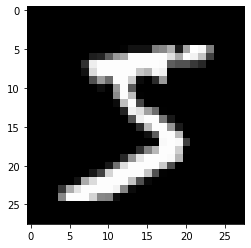

In [3]:
draw_image(img[0])

* 불러온 이미지을 **preProcessing** 함수를 통해 데이터셋으로 전환합시다.

In [3]:
def preProcessing(img, img_test):

    # reshape
    print('* Reshape')
    x_train = np.reshape(img, (img.shape[0],img.shape[1]*img.shape[2]*1))
    x_test = np.reshape(img_test, (img_test.shape[0], img_test.shape[1]*img_test.shape[2]*1))
    print(x_train.shape)
    print(x_test.shape)
    
    # Normalize
    print('* Normailze')
    x_train = x_train / 255
    x_test = x_test / 255
    print(x_train.shape)
    print(x_test.shape)
    
    return x_train, x_test

In [4]:
x_train, x_test = preProcessing(img, img_test)

* Reshape
(60000, 784)
(10000, 784)
* Normailze
(60000, 784)
(10000, 784)


----
# [ 1 ]



In [6]:
from tensorflow.keras import layers, models
from functools import partial

def make_model_1():
    Dense = partial(layers.Dense, # 필요한 레이어를 사전 정의하는 함수
               activation='elu',
               kernel_initializer='he_normal',
               )

    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=(28*28,)),
        Dense(300),
        Dense(100),
        layers.Dense(10, activation='softmax')
    ])

    model.summary()
    return model

In [9]:
#모델 생성
model=make_model_1()

# 모델 컴파일
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 콜백 선언
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('results_11-2/model_1.h5', save_best_only=True)

# 모델 훈련
model.fit(x_train, y_train, 
          validation_split=0.2,
          epochs=10,
          callbacks=[model_checkpoint_cb])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2508 - accuracy: 0.9230 - val_loss: 0.1678 - val_accuracy: 0.9503
Epoch 2/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1154 - accuracy: 0.9641 - val_loss: 0.1186 - val_accuracy: 0.9651
Epoch 3/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0772 - accur

In [10]:
model_1 = tf.keras.models.load_model('results_11-2/model_1.h5')
m1_test = model_1.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0847 - accuracy: 0.9764


In [16]:
y_pred = model_1.predict(x_test)
y_pred_class = np.argmax(y_pred, axis=1)
print("정확도:", sum(y_pred_class == y_test)/10000*100, "%")

정확도: 97.64 %


----
# [ 2 ] l1 norm

https://m.blog.naver.com/PostView.nhn?blogId=sky3000v&logNo=221536661344&proxyReferer=https:%2F%2Fwww.google.com%2F

* L1 규제: L1의 경우에는 가중치의 크기에 상관없이 상수값을 뺍니다. 이는 대체적으로 불필요한 가중치의 수치를 0으로 만들도록 하는 방향으로 적용됩니다. 즉, 중요한 가중치만을 취하기 때문에 sparse feature에 대한 모델을 구성하는데 적합합니다.


* L2 규제: L2의 경우에는 가중치의 값을 이용합니다. 어느 정도 튀는 값에 대해 대응할 수 있다는 소리죠. 따라서, 이상치나 노이즈가 있는 데이터에 대한 학습을 진행할 때 사용하면 좋습니다. 특히 선형 모델의 일반화에 좋다고 합니다.     



<br>

##### Glorot Initialization 또는 Xavier Initialization

<br>

* 활성화 함수가 없거나, 하이퍼볼릭 탄젠트(tanh, hyperbolic tangent), 로지스틱(Logistic Sigmoid), 소프트맥스(SoftMax) 함수 등에는,


* $fan_{avg} = \frac{(fan_{in}+fan_{out})}{2} $ 일 때,


* 평균이 0, 분산이 $\sigma^{2} = \frac{1}{fan_{out}}$ 인 정규 분포 (normal dist)


* $r = \sqrt{\frac{3}{fan_{avg}}}$ 일때, $-r$과 $+r$ 사이의 균등 분포 (uniform dist)

<br>

In [19]:
from tensorflow.keras import layers, models
from functools import partial

def make_model_2():
    RegularizedDense = partial(layers.Dense, # 필요한 레이어를 사전 정의하는 함수
               activation='elu',
               kernel_initializer='he_normal',
               kernel_regularizer=tf.keras.regularizers.l1(0.01) # l1 norm 사용
               )

    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=(28*28,)),
        RegularizedDense(300),
        RegularizedDense(100),
        layers.Dense(10, activation='softmax', 
                    kernel_initializer="glorot_uniform")
    ])

    model.summary()
    return model

* 콜백 ModelCheckpoint의 저장 이름을 **2_model.h5**로 바꿉니다.


In [20]:
#모델 생성
model=make_model_2()

# 모델 컴파일
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 콜백 선언
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('results_11-2/model_2.h5', 
                                                         save_best_only=True)

# 모델 훈련
model.fit(x_train, y_train, 
          validation_split=0.2,
          epochs=10,
          callbacks=[model_checkpoint_cb])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_7 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1500/1500 [==============================] - 9s 6ms/step - loss: 4.7989 - accuracy: 0.7917 - val_loss: 1.4072 - val_accuracy: 0.8572
Epoch 2/10
1500/1500 [==============================] - 8s 6ms/step - loss: 1.3619 - accuracy: 0.8533 - val_loss: 1.2760 - val_accuracy: 0.8714
Epoch 3/10
1500/1500 [==============================] - 8s 5ms/step - loss: 1.2861 - accur

In [21]:
model_2 = tf.keras.models.load_model('results_11-2/model_2.h5')
m2_test = model_2.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.1000 - accuracy: 0.8829


In [22]:
y_pred = model_2.predict(x_test)
y_pred_class = np.argmax(y_pred, axis=1)
print("정확도:", sum(y_pred_class == y_test)/10000*100, "%")

정확도: 88.29 %


----
# [  3 ]  l2 norm

In [24]:
from tensorflow.keras import layers, models
from functools import partial

def make_model_3():
    RegularizedDense = partial(layers.Dense, # 필요한 레이어를 사전 정의하는 함수
               activation='elu',
               kernel_initializer='he_normal',
               kernel_regularizer=tf.keras.regularizers.l2(0.01) # l2 norm 사용
               )

    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=(28*28,)),
        RegularizedDense(300),
        RegularizedDense(100),
        layers.Dense(10, activation='softmax', 
                    kernel_initializer="glorot_uniform")
    ])

    model.summary()
    return model

* 콜백 ModelCheckpoint의 저장 이름을 **3_model.h5**로 바꿉니다.

In [25]:
#모델 생성
model=make_model_3()

# 모델 컴파일
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 콜백 선언
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('results_11-2/model_3.h5', 
                                                         save_best_only=True)

# 모델 훈련
model.fit(x_train, y_train, 
          validation_split=0.2,
          epochs=10,
          callbacks=[model_checkpoint_cb])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_10 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1500/1500 [==============================] - 8s 6ms/step - loss: 1.1257 - accuracy: 0.8742 - val_loss: 0.5747 - val_accuracy: 0.8999
Epoch 2/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.5536 - accuracy: 0.9003 - val_loss: 0.4967 - val_accuracy: 0.9153
Epoch 3/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.4939 - accur

In [26]:
model_3 = tf.keras.models.load_model('results_11-2/model_3.h5')
m3_test = model_3.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3713 - accuracy: 0.9403


In [27]:
y_pred = model_3.predict(x_test)
y_pred_class = np.argmax(y_pred, axis=1)
print("정확도:", sum(y_pred_class == y_test)/10000*100, "%")

정확도: 94.03 %


----
# [  4 ] DropOut

In [28]:
from tensorflow.keras import layers, models
from functools import partial

def make_model_4():
    Dense = partial(layers.Dense, # 필요한 레이어를 사전 정의하는 함수
               activation='elu',
               kernel_initializer='he_normal',
    #           kernel_regularizer=tf.keras.regularizers.l2(0.01) 
               )

    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=(28*28,)),
        layers.Dropout(rate=0.2),
        Dense(300),
        layers.Dropout(rate=0.2),
        Dense(100),
        layers.Dropout(rate=0.2),
        layers.Dense(10, activation='softmax', 
                    kernel_initializer="glorot_uniform")
    ])

    model.summary()
    return model


* 콜백 ModelCheckpoint의 저장 이름을 **4_model.h5**로 바꿉니다.


In [29]:
#모델 생성
model=make_model_4()

# 모델 컴파일
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 콜백 선언
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('results_11-2/model_4.h5', 
                                                         save_best_only=True)

# 모델 훈련
model.fit(x_train, y_train, 
          validation_split=0.2,
          epochs=10,
          callbacks=[model_checkpoint_cb])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 300)               235500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               30100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
________________________________________________

In [30]:
model_4 = tf.keras.models.load_model('results_11-2/model_4.h5')
m4_test = model_4.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0750 - accuracy: 0.9748


In [31]:
y_pred = model_4.predict(x_test)
y_pred_class = np.argmax(y_pred, axis=1)
print("정확도:", sum(y_pred_class == y_test)/10000*100, "%")

정확도: 97.48 %


# [ 5 ]

* 지금까지 만든 4가지 모델을 불러오고 평가해 봅니다.
* **tf.keras.models.load_model( )**을 통해 모델을 불러올 수 있습니다.
* **model.evaluate( )**를 통해 모든 모델을 평가해 봅니다.
* 불러오기 전에 아래 셀에서 각 모델의 특징을 간단히 메모하세요

* model_1: Adam, Dense(Elu & He_normal)
* model_2: L1 Norm (l1=0.01), Adam, Dense(Elu & He_normal), Output layer(softmax & glorot_uniform)
* model_3: L2 Norm (l2=0.01), Adam, Dense(Elu & He_normal), Output layer(softmax & glorot_uniform)
* model_4: DropOut (rate=0.2),  Adam, Dense(Elu & He_normal), Output layer(softmax & glorot_uniform)

In [19]:
# 모델 불러오기
model_1 = tf.keras.models.load_model('results_11-2/model_1.h5')
model_2 = tf.keras.models.load_model('results_11-2/model_2.h5')
model_3 = tf.keras.models.load_model('results_11-2/model_3.h5')
model_4 = tf.keras.models.load_model('results_11-2/model_4.h5')


In [32]:
# 모델 평가
m1_test = model_1.evaluate(x_test, y_test)
m2_test = model_2.evaluate(x_test, y_test)
m3_test = model_3.evaluate(x_test, y_test)
m4_test = model_4.evaluate(x_test, y_test)
print("m1:", m1_test, "\n",
      "m2:", m2_test, "\n",
      "m3:", m3_test, "\n",
      "m4:", m4_test)

313/313 [==============================] - ETA: 0s - loss: 0.0737 - accuracy: 0.97 - 1s 3ms/step - loss: 0.0750 - accuracy: 0.9748
m1: [0.08466541767120361, 0.9764000177383423] 
 m2: [1.099966049194336, 0.8828999996185303] 
 m3: [0.37132662534713745, 0.9402999877929688] 
 m4: [0.07503607869148254, 0.9747999906539917]
